In [3]:
import sklearn.ensemble as ensemble
import sklearn.linear_model as lr
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import re

from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Oversampling/Undersampling
from imblearn import over_sampling, under_sampling

## Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Evaluate original and resampled
from imblearn.metrics import classification_report_imbalanced

In [4]:
# Credit-card kaggle
cc_df = pd.read_csv("creditcard.csv")

# X: features
x_cc = cc_df.iloc[:,1:30]
x_cc = np.array(x_cc)

# Y: labels
y_cc = cc_df['Class'].values

# Original
x_train, x_test, y_train, y_test = train_test_split(
    x_cc,
    y_cc,
    random_state=42)

### Boosting
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/  
A family of algorithms that converts weak learners to strong learners. Take random samples of data, use model to predict, subsequently give more weight to misclassified observations.

AdaBoost: boosting algorithms using decision stumps (line to seperate class) It fits a sequence of weak learners on different weighted training data. It starts by predicting original data set and gives equal weight to each observation. If prediction is incorrect using the first learner, then it gives higher weight to observation which have been predicted incorrectly. Being an iterative process, it continues to add learner(s) until a limit is reached in the number of models or accuracy. [Regression, Classification]

Step 1: Make decision stump using decision tree?  
Step 2: Give additional weight to misclassified observations  
Step 3: Repeat process & combine all stumps to get final classifier

Gradient Boosting:  
Step 1 : Assume mean is the prediction of all variables.

Step 2 : Calculate errors of each observation from the mean (latest prediction).

Step 3 : Find the variable that can split the errors perfectly and find the value for the split. This is assumed to be the latest prediction.

Step 4 : Calculate errors of each observation from the mean of both the sides of split (latest prediction).

Step 5 : Repeat the step 3 and 4 till the objective function maximizes/minimizes.

Step 6 : Take a weighted mean of all the classifiers to come up with the final model.

### XGBoost

As XGBoost's objective cannot be optimized using traditional optimization methods in Euclidean space, _Taylor's Theorem_ is used to transform the original objective to a function in the Euclidean domain, that traditional optimization techniques could be used.

After getting the simplified objecitve using _Taylor's Theorem_, we minimize it


Parameter tuning:
- Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
- Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
- Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
- Lower the learning rate and decide the optimal parameters .


In [8]:
# Model + Resampling pipelines
# https://hackernoon.com/how-to-develop-a-robust-algorithm-c38e08f32201
# lr.ElasticNet(random_state=42,),
models = [lr.LogisticRegression(solver='lbfgs',
                                random_state=42,
                                max_iter=1000),
        ensemble.RandomForestClassifier(random_state=42,),
        ensemble.GradientBoostingClassifier(random_state=42, subsample=0.8),
        ensemble.AdaBoostClassifier(random_state=42,),
         XGBClassifier(random_state=42)]

samplers = [over_sampling.SMOTE(random_state=42, sampling_strategy=0.5),
          over_sampling.ADASYN(random_state=42),
          over_sampling.RandomOverSampler(random_state=42),
            over_sampling.SVMSMOTE(random_state=42),          
            over_sampling.BorderlineSMOTE(random_state=42,kind='borderline-1'),
            under_sampling.ClusterCentroids(random_state=42), 
            under_sampling.RandomUnderSampler(random_state=42),  
            under_sampling.NearMiss(random_state=42, version=3),
            under_sampling.TomekLinks(), 
            under_sampling.EditedNearestNeighbours(),
            under_sampling.NeighbourhoodCleaningRule(),
            under_sampling.OneSidedSelection()
           ]

/home/jan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


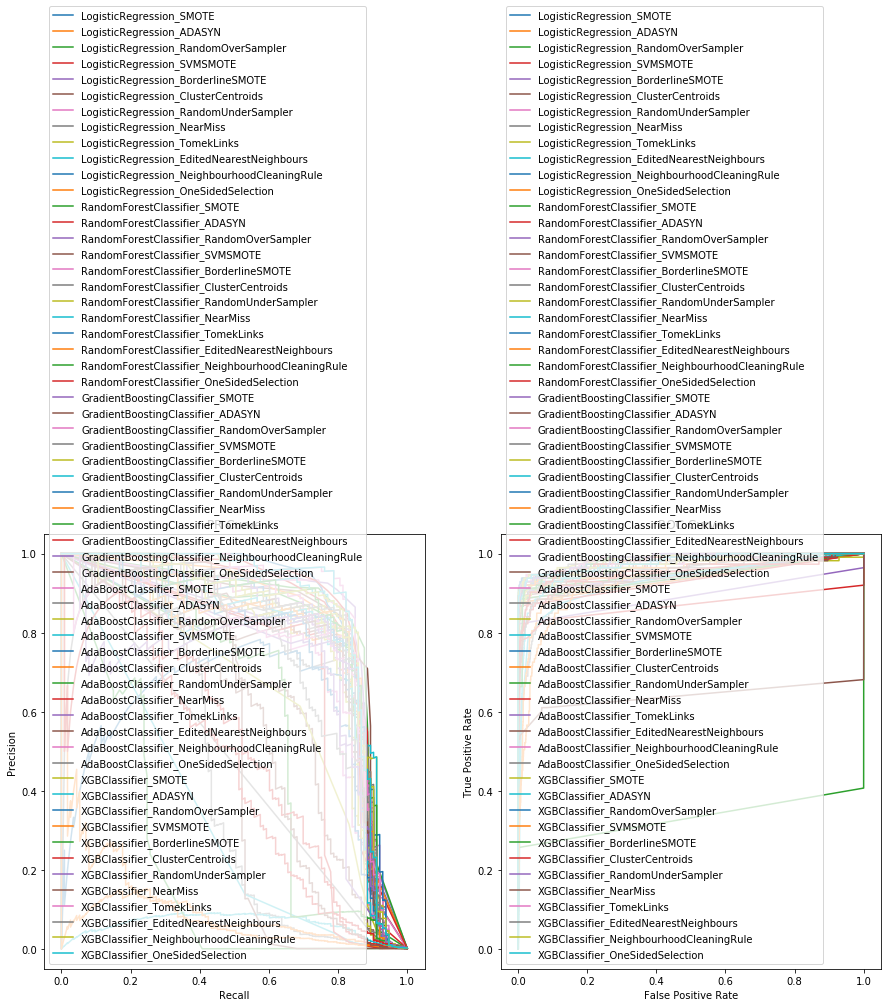

In [9]:
# https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for model in models:
    for sample in samplers:
        
        ## Pipe
        pl = make_pipeline_imb(sample, model)
        
        ## Train
        pl.fit(x_train, y_train)
        
        ## Predict Proba
        pred_prob = pl.predict_proba(x_test)[:,1]
        p,r,_ = precision_recall_curve(y_test,pred_prob)
        tpr,fpr,_ = roc_curve(y_test,pred_prob)
        
        ## Legend
        legend = re.match(r'(.+?)\(.+?',str(model)).group(1) + '_' + re.match(r'(.+?)\(.+?',str(sample)).group(1)
        
        ## Plot
        ax1.plot(r, p, label=legend)
        ax2.plot(tpr, fpr, label=legend)
        
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()

In [11]:
# Better iteration
models = [(lr.LogisticRegression(solver='lbfgs',
                                random_state=42,
                                max_iter=1000),
          under_sampling.EditedNearestNeighbours(random_state=42)),
        (ensemble.RandomForestClassifier(random_state=42),
         under_sampling.NearMiss(random_state=42, version=3)),
        (ensemble.GradientBoostingClassifier(random_state=42, subsample=0.8),
        under_sampling.ClusterCentroids(random_state=42)),
        (ensemble.AdaBoostClassifier(random_state=42), 
         over_sampling.SVMSMOTE(random_state=42)),
         (XGBClassifier(random_state=42),
          over_sampling.ADASYN(random_state=42)),
         (XGBClassifier(random_state=42),
         under_sampling.OneSidedSelection(random_state=42))]

/home/jan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


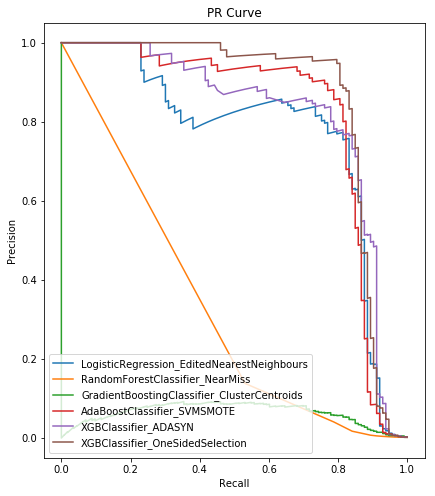

In [17]:
# https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

for model in models:
 

    ## Pipe
    pl = make_pipeline_imb(model[1], model[0])

    ## Train
    pl.fit(x_train, y_train)

    ## Predict Proba
    pred_prob = pl.predict_proba(x_test)[:,1]
    p,r,_ = precision_recall_curve(y_test,pred_prob)
    tpr,fpr,_ = roc_curve(y_test,pred_prob)

    ## Legend
    legend = re.match(r'(.+?)\(.+?',str(model[0])).group(1) + '_' + re.match(r'(.+?)\(.+?',str(model[1])).group(1)

    ## Plot
    ax1.plot(r, p, label=legend)

ax1.legend(loc='lower left')    
plt.show()

Text(0.5, 1.0, 'PR Curve')

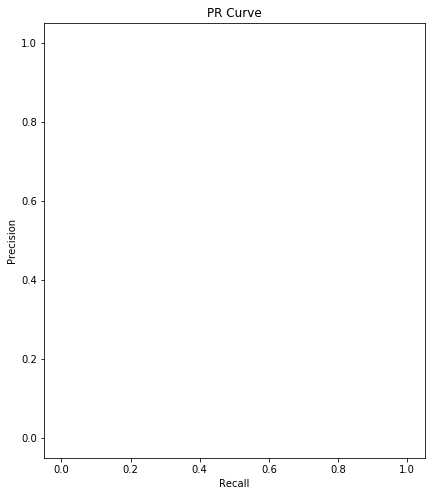

In [15]:
# First Draft
# https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for model in models:
    for sample in samplers:

        ## Pipe
        pl = make_pipeline_imb(sample, model)

        ## Train
        pl.fit(x_train, y_train)

        ## Predict Proba
        pred_prob = pl.predict_proba(x_test)[:,1]
        p,r,_ = precision_recall_curve(y_test,pred_prob)
        tpr,fpr,_ = roc_curve(y_test,pred_prob)

        ## Legend
        legend = re.match(r'(.+?)\(.+?',str(model)).group(1) + '_' + re.match(r'(.+?)\(.+?',str(sample)).group(1)

        ## Plot
        ax1.plot(r, p, label=legend)
        ax2.plot(tpr, fpr, label=legend)

ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()

In [50]:
for model in models:
    for sample in samplers:
        ## Pipe
        pl = make_pipeline_imb(sample, model)
        
        ## Legend
        legend = re.match(r'(.+?)\(.+?',str(model)).group(1) + '_' + re.match(r'(.+?)\(.+?',str(sample)).group(1)
        
        print(legend)
        print(classification_report_imbalanced(y_test, pl.predict(x_test)))

LogisticRegression_SMOTE
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.92      0.99      0.95      0.90     71089
          1       0.06      0.92      0.98      0.11      0.95      0.89       113

avg / total       1.00      0.98      0.92      0.99      0.95      0.90     71202

LogisticRegression_ADASYN
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.92      0.99      0.95      0.90     71089
          1       0.06      0.92      0.98      0.11      0.95      0.89       113

avg / total       1.00      0.98      0.92      0.99      0.95      0.90     71202

LogisticRegression_RandomOverSampler
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.92      0.99      0.95      0.90     71089
          1       0.06      0.92      0.98      0.11      0.95      0.89   

RandomForest seems to perform the best. 

Since the RF classifier tends to be biased towards the majority class, we shall place a heavier penalty on misclassifying the minority class. BRF is computationally more efficient with large imbalanced data, since each tree only uses a small portion of the training set to grow, while WRF needs to use the entire training set. WRF assigns a weight to the minority class, possibly making it more vulnerable to noise (mis-labeled class) than BRF. A majority case that is mislabled as belonging to the minority class may have a larger effect on the prediction accuracy of the majority class in WRF than in BRF.

### Difference in BalancedRandomForestClassifier and RUS + RF

In [4]:
RUS = under_sampling.RandomUnderSampler(sampling_strategy='auto',
                                        return_indices=False,
                                        random_state=42,
                                        replacement=False,
                                        ratio=None)

In [37]:
RF = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=42,
    verbose=0,
    warm_start=False,
    class_weight=None)

In [38]:
pl_RUS_RF = make_pipeline_imb(RUS, RF)

In [39]:
pl_RUS_RF.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('randomundersampler',
                 RandomUnderSampler(random_state=42, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy='auto')),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=1,
                                        oob_score=False, random_stat

In [40]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [41]:
BRF = BalancedRandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    sampling_strategy='auto',
    replacement=False,
    n_jobs=1,
    random_state=42,
    verbose=0,
    warm_start=False,
    class_weight=None)

In [42]:
BRF.fit(x_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=1, oob_score=False, random_state=42,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [43]:
print(classification_report_imbalanced(y_test, BRF.predict(x_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.92      0.99      0.95      0.91     71089
          1       0.07      0.92      0.98      0.12      0.95      0.90       113

avg / total       1.00      0.98      0.92      0.99      0.95      0.91     71202



In [36]:
print(classification_report_imbalanced(y_test, pl_RUS_RF.predict(x_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.97      0.91      0.99      0.94      0.89     71089
          1       0.05      0.91      0.97      0.10      0.94      0.88       113

avg / total       1.00      0.97      0.91      0.99      0.94      0.89     71202

